# Optimización del portafolio tipo sharpe con multiplicadores de Lagrange

## Definición del problema

Se busca optimizar el sharpe ratio de un portafolio mediante el uso de multiplicadores de lagrange. Para ello definimos lo siguiente:

- $w = [w_1,w_2,...,w_n]$ : vector de pesos de los activos del portafolio
- $\mu = [\mu_1,\mu_2,...,\mu_3]$ : vector del valor esperado de cada uno de los activos
- $\Sigma$: la matriz de covarianza de los rendimientos de los activos
- $rf$: la tasa libre de riesgo

El sharpe ratio se define de la siguiente manera:
$$ S = \frac{R_p-r_f}{\sigma_p} $$

esto adaptado a nuestro problema se define como:
$$ S = \frac{w^T\mu - rf}{\sqrt{w^T\Sigma w}} $$

donde:
- $w^T\mu$ es la rentabilidad del portafolio
- $w^T \Sigma w$ es la varianza del portafolio


## Formulación del problema

Lo que buscamos es
$$ max\; S = \frac{w^T\mu - rf}{\sqrt{w^T\Sigma w}} $$

Este problema es complicado de maximizar directamente porque es una fracción con una raíz cuadrada en el denominador. Sin embargo, con una reformulación, podemos plantear el problema como una maximización del rendimiento ajustado por riesgo bajo la restricción de varianza constante.

Por lo tanto planteamos el problema de la siguiente manera:
$$ \max\; w^T\mu - r_f $$
$$ s.t.\; w^T \Sigma w = \sigma^2 $$

Ahora planteamos el problema utilizando multiplicadores de Lagrange:

$$\mathcal{L}(w,\lambda) = w^T\mu - r_f + \lambda(\sigma^2 - w^T \Sigma w)$$

Obtenemos las derivadas parciales e igualamos a 0 para la optimización:

$\frac{\partial \mathcal{L}}{\partial w} = 0 \Rightarrow \mu - 2\lambda \Sigma w = 0$

$\frac{\partial \mathcal{L}}{\partial \lambda} = 0 \Rightarrow \sigma^2 - w^T \Sigma w = 0$

Despejando obtenemos lo siguiente:

- 1: $w = \frac{\Sigma^{-1} \mu}{2 \lambda}$
- 2: $\sigma^2 = w^T \Sigma w$

Ahora debemos darle solución al sistema de ecuaciones obtenido, para conocer el valor del vectr $w$.

Sustituyendo $w$ en la segunda ecuación tenemos:

$\sigma^2 = (\frac{1}{2\lambda} \Sigma^{-1} \mu)^T \Sigma (\frac{1}{2\lambda} \Sigma^{-1} \mu)$

$\sigma^2 = \frac{1}{2\lambda} \mu^T \Sigma^{-1^T}\Sigma \frac{1}{2\lambda} \Sigma^{-1} \mu$

$\sigma^2 = \frac{1}{4\lambda^2} \mu^T \Sigma^{-1^T}\Sigma \Sigma^{-1} \mu$


Como $ \Sigma^{-1^T}\Sigma = I $ tenemos que:

$\sigma^2 = \frac{1}{4\lambda^2} \mu^T \Sigma^{-1} \mu$

$\lambda^2 = \frac{1}{4\sigma^2} \mu^T \Sigma^{-1} \mu$

$\lambda = \frac{\sqrt{\mu^T\Sigma^{-1}\mu}}{2\sigma}$

Ya habiendo despejado $\lambda$, lo podemos sustituir en la primer ecuacion:

$w = \frac{\Sigma^{-1} \mu}{2(\frac{\sqrt{\mu^T \Sigma^{-1} \mu}}{2\sigma})}$

$w = \frac{\Sigma^{-1} \mu}{\frac{\sqrt{\mu^T \Sigma^{-1} \mu}}{\sigma}}$

$w = \frac{\sigma \Sigma^{-1} \mu}{\sqrt{\mu^T \Sigma^{-1} \mu}}$

## Consideración de la tasa libre de riesgo

La fórmula obtenida para $w$, debido al método de multiplicadores de Lagrange no incluye a $r_f$, pues al ser una constante, está se hace 0 en el proceso de derivación, por lo tanto para calcular $w$ considerando la tasa libre de riesgo la fórmula queda de la siguiente manera:
$$ w = \frac{\sigma \Sigma^{-1} (\mu-r_f)}{\sqrt{(\mu-r_f)^T \Sigma^{-1} (\mu-r_f)}}  $$

## Normalización del vector $w$

Para que la fórmula funcione correctamente necesitamos normalizar el vector $w$ y con ello obtener $w^*$

Entonces:

$$w^* = \frac{w}{\sum_{i=1}^{n} w_i}$$

donde:
- $w_i$: valor en la i-ésima posición del vector $w$
- $n$: número total de elementos en $w$

## Conclusiones

Ya con esto podemos calcular retorno, el riesgo, y el sharpe del portafolio óptimo con las siguientes fórmulas:

- $R_p = w^{*^T}\mu$
- $\sigma = \sqrt{ w^{*T} \Sigma w^* }$
- $S = \frac{R_p}{\sigma}$

Como en el cálculo de $w$ a $\mu$ ya se le resto $r_f$, para obtener el sharpe ratio no es necesario restar $r_f$ al retorno del portafolio.

Los valores obtenidos para $w$ pueden ser mayores a 1 o menores a 0. Si un valor es mayor que 1, indica que se ha utilizado apalancamiento en esa posición; mientras que si es menor que 0, significa que se ha tomado una posición corta en dicho activo.

Además si se desea modificar el retorno y riesgo esperado del portafolio, este se puede ajustar al multiplicar el vector $w^*$ por un valor de $\alpha$. A continuación se muestra el código para realizar los cálculos necesarios para obtener el portafolio con el valor del sharpe ratio más alto.


## Código

### Librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Markdown
from ipywidgets import interact, FloatSlider

### Descarga de datos

In [2]:
tickers=['CRM','GLD','GOOGL','JPM','MCD','META','F','V','COST','XOM']

f_inicial='2020-01-01'
f_final='2024-11-10'

datos1=yf.download(tickers,f_inicial,f_final)['Adj Close']

rt = datos1.pct_change().dropna()


[*********************100%***********************]  10 of 10 completed


### Obtención de matrices y vectores importantes

In [3]:
mu = (rt.mean() * 252).values  # Rendimientos esperados
rf = 0.05  # Tasa libre de riesgo
sigma = rt.cov().values  # Matriz de covarianzas
sigma_inv = np.linalg.inv(sigma)  # Matriz de varianza-covarianza inversa
mu_rf = mu - rf # Rendimientos esperados en exceso
unos = np.ones(len(mu)) # Vector de unos


### Ejecución de la fórmula obtenida

In [4]:
w = (1 * np.dot(sigma_inv,mu_rf)) / np.sqrt(np.dot(mu_rf.T,np.dot(sigma_inv,mu_rf)))
w_opt = w / np.sum(w)

ret = np.dot(w_opt, mu_rf)
risk = np.sqrt(np.dot(w_opt.T, np.dot(sigma, w_opt))) * np.sqrt(252)

sharpe = ret / risk

w_opt_df = pd.DataFrame(w_opt, index=tickers, columns=['w*'])

print(f'Return: {ret:.6f}')
print(f'Risk: {risk:.6f}')
print(f'Sharpe ratio: {sharpe:.6f}')
display(Markdown(f'Valores del vector $w^*$:'))
display(w_opt_df.T)

Return: 0.215421
Risk: 0.183984
Sharpe ratio: 1.170868


Valores del vector $w^*$:

,CRM,GLD,GOOGL,JPM,MCD,META,F,V,COST,XOM
w*,0.618121,-0.054382,-0.05637,0.343098,0.070334,0.096268,-0.071874,0.098767,-0.237236,0.193274


Return: 0.215421
Risk: 0.183984
Sharpe ratio: 1.170868

Adjusted Weights:
CRM: 0.618121
GLD: -0.054382
GOOGL: -0.056370
JPM: 0.343098
MCD: 0.070334
META: 0.096268
F: -0.071874
V: 0.098767
COST: -0.237236
XOM: 0.193274


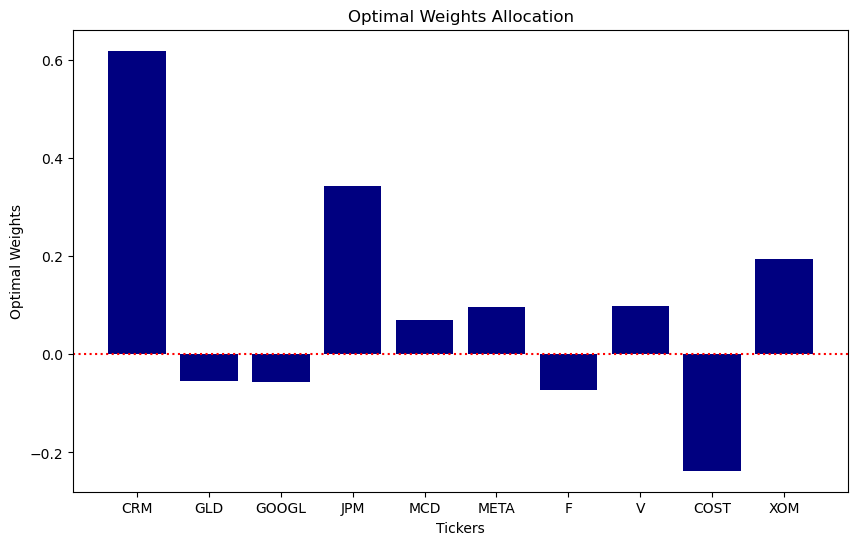

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, w_opt, color='navy')
plt.axhline(0, color='red', linestyle=':')
plt.xlabel('Tickers')
plt.ylabel('Optimal Weights')
plt.title('Optimal Weights Allocation')
print(f'Return: {ret:.6f}')
print(f'Risk: {risk:.6f}')
print(f'Sharpe ratio: {sharpe:.6f}')
print()
print("Adjusted Weights:")
for ticker, weight in zip(tickers, w_opt):
    print(f"{ticker}: {weight:.6f}")

### Cambios en los pesos de $w^*$ moviendo $\alpha$

Se decide multiplicar el vector $w^*$ por un valor escalar $\alpha$, para ver como cambian los pesos del portafolio.

In [6]:
def update_plot(alpha):
    adjusted_weights = w_opt * alpha
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, adjusted_weights, color='navy')
    plt.axhline(0, color='red', linestyle=':')
    plt.xlabel('Tickers')
    plt.ylabel('Optimal Weights')
    plt.title('Optimal Weights Allocation')
    ret = np.dot(adjusted_weights, mu_rf)
    risk = np.sqrt(np.dot(adjusted_weights.T, np.dot(sigma, adjusted_weights))) * np.sqrt(252)

    sharpe = ret / risk
    print(f'Return: {ret:.6f}')
    print(f'Risk: {risk:.6f}')
    print(f'Sharpe ratio: {sharpe:.6f}')
    print()
    print("Adjusted Weights:")
    for ticker, weight in zip(tickers, adjusted_weights):
        print(f"{ticker}: {weight:.6f}")
    plt.show()

interact(update_plot, alpha=FloatSlider(value=1, min=0, max=2, step=0.05))



interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, step=0.05), Output()), _dom_classes…

<function __main__.update_plot(alpha)>

## Optminización con scipy

In [7]:
# Número de activos
n = len(mu)

# Función objetivo (negativo del Sharpe ratio)
def objective(w):
    port_return = np.dot(w, mu)
    port_volatility = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
    return -(port_return - rf) / port_volatility

# Restricción: la suma de los pesos debe ser 1
def constraint(w):
    return np.sum(w) - 1

# Restricciones y límites
cons = ({'type': 'eq', 'fun': constraint})
bnds = [(0, 1) for _ in range(n)]  # Si deseas que los pesos sean entre 0 y 1

# Valores iniciales de los pesos
w0 = np.ones(n) / n

# Optimización
result = minimize(objective, w0, method='SLSQP', bounds=bnds, constraints=cons)

In [8]:
# Create a DataFrame for the optimal weights
weights_df = pd.DataFrame(np.round(result.x,7), index=tickers, columns=['Optimal Weights'])

# Calculate the portfolio return and risk
portfolio_return = np.dot(result.x, mu)
portfolio_risk = np.sqrt(np.dot(result.x.T, np.dot(sigma, result.x))) * np.sqrt(252)

# Print the DataFrame
display(weights_df.T)

# Print the maximum Sharpe ratio
print("\nMaximum Sharpe Ratio:", -result.fun)
print(portfolio_return)
print(portfolio_risk)

,CRM,GLD,GOOGL,JPM,MCD,META,F,V,COST,XOM
Optimal Weights,0.501315,0.0,0.0,0.31758,0.0,0.0,0.0,0.059605,0.0,0.121499



Maximum Sharpe Ratio: 1.0992424029990813
0.2300870045330674
0.1638282912319731


## Fórmula de optimización de chat

In [9]:

w_chat = np.dot(sigma_inv,mu_rf)/ np.dot(unos.T,np.dot(sigma_inv,mu_rf))
ret_chat = np.dot(w_chat, mu_rf)
risk_chat = np.sqrt(np.dot(w_chat.T, np.dot(sigma, w_chat))) * np.sqrt(252)

sharpe = ret_chat / risk_chat
print(f'Return: {ret_chat:.6f}')
print(f'Risk: {risk_chat:.6f}')
print(f'Sharpe ratio: {sharpe:.6f}')
print(w_chat)

Return: 0.215421
Risk: 0.183984
Sharpe ratio: 1.170868
[ 0.61812113 -0.05438207 -0.05636969  0.343098    0.07033434  0.09626789
 -0.07187389  0.0987669  -0.23723617  0.19327357]


## Fórmula de optimización obtenida

In [10]:
w = (1 * np.dot(sigma_inv,mu)) / np.sqrt(np.dot(mu.T,np.dot(sigma_inv,mu)))
w_opt = w / np.sum(w)

ret = np.dot(w_opt, mu)
risk = np.sqrt(np.dot(w_opt.T, np.dot(sigma, w_opt))) * np.sqrt(252)

sharpe = (ret - rf) / risk
print(f'Return: {ret:.6f}')
print(f'Risk: {risk:.6f}')
print(f'Sharpe ratio: {sharpe:.6f}')
print(w)

Return: 0.229653
Risk: 0.156287
Sharpe ratio: 1.149509
[ 47.69892213  -4.70986084  -4.6223221   44.49371636   5.09370953
   8.86258387  -0.85568694   6.52206023 -15.10819591  14.19813603]
